In [186]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sys import modules
import seaborn as sns
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [498]:
#Import Data 
X_data= pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/X.csv")
y_data = pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/y.csv")

#Set index
X_data = X_data.set_index('id')
y_data = y_data.set_index('id')

#join
df = X_data.join(y_data, on = 'id') 
print(df.shape)

(5363, 13)


In [500]:
#Copy
#Run this for raw data
input_df = df
df = input_df.copy()

#Check data shape
print(df.shape)

#Columns and type
print(df.info())

(5355, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5355 entries, 2477 to 3572
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5355 non-null   float64
 1   Gender               5355 non-null   object 
 2   Education Level      5355 non-null   object 
 3   Job Title            5355 non-null   object 
 4   Years of Experience  5355 non-null   float64
 5   Country              5355 non-null   object 
 6   Race                 5355 non-null   object 
 7   height               5355 non-null   float64
 8   weight               5355 non-null   float64
 9   professionalism      5355 non-null   float64
 10  Salary               5355 non-null   float64
dtypes: float64(6), object(5)
memory usage: 502.0+ KB
None


In [499]:
#Drop
#Shape after Drop Null
df = df.dropna()
print(df.shape)

#Drop Retendent Columns
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
print(df.shape)

(5355, 13)
(5355, 11)


In [193]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(4284, 11)
(1071, 11)


In [194]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0


In [195]:
X_train, y_train = df_train.drop("Salary", axis=1), df_train["Salary"]
X_test, y_test = df_test.drop("Salary", axis=1), df_test["Salary"]

In [196]:
def my_stupid_evaluation_function(y_test,y_pred, tolerance = 0.1):
    out = np.abs(y_test-y_pred)/ y_test
    return (out<tolerance).mean()

In [198]:
class MyModel:
    def __init__ (self, col):
        self.col = col

    def fit(self, X, y):
        
        #x and y are the ones from the training set
        self.col_salary_mapper_ = y.groupby(X[self.col]).mean().rename("y_hat") 
        self.fallback_salary_ = y.mean()

    def predict(self, X):
        """"We"""
        out = X.join(self.col_salary_mapper_, on = self.col)
        out = out["y_hat"]
        out = out.fillna(self.fallback_salary_) #what we didnt predict well will be in fallback price
        return out
    
score_board = {}
score_board_mse = {}
for col in X_train.columns:
    reg = MyModel(col = col)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_mse = mean_absolute_error(y_test, y_pred)
    score_board_mse[col] = my_mse

In [199]:
#Base evaluation funtion
pd.Series(score_board)

Age                    0.302521
Gender                 0.163399
Education Level        0.197012
Job Title              0.333333
Years of Experience    0.350140
Country                0.134454
Race                   0.136321
height                 0.117647
weight                 0.117647
professionalism        0.471522
dtype: float64

In [200]:
#we found that professionalism yield the best score
reg = MyModel(col = "professionalism")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [201]:
y_test.to_frame().join(y_pred)

,Salary,y_hat
id,,
1639,150000.0,125882.352941
1915,190000.0,165000.000000
1568,140000.0,121815.161290
1475,70000.0,58270.833333
2766,160000.0,144583.333333
...,...,...
6025,30000.0,51587.864078
5024,110000.0,114054.642857
421,190000.0,122916.522727


In [202]:
best_col = pd.Series(score_board).idxmax()

#we found that professionalism yield the best score
reg = MyModel(col = best_col)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

"""2/3 ways for join """
y_test.to_frame().join(y_pred)
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

evaluation_df

,y_test,y_pred
id,,
1639,150000.0,125882.352941
1915,190000.0,165000.000000
1568,140000.0,121815.161290
1475,70000.0,58270.833333
2766,160000.0,144583.333333
...,...,...
6025,30000.0,51587.864078
5024,110000.0,114054.642857
421,190000.0,122916.522727


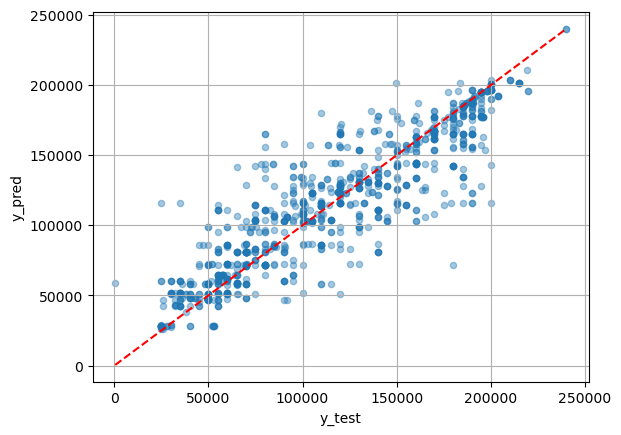

In [203]:
# Create a scatter plot using DataFrame column names
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line

In [204]:
reg.col_salary_mapper_

professionalism
0.0        28446.814286
22.0       25000.000000
23.0       46481.357143
24.0       60350.443038
25.0       51587.864078
              ...      
1710.0    121450.000000
1728.0    192480.142857
1736.0    197354.000000
1881.0    188232.000000
2040.0    188651.000000
Name: y_hat, Length: 265, dtype: float64

In [205]:
reg.fallback_salary_

115793.8779178338

In [206]:
y_pred

id
1639    125882.352941
1915    165000.000000
1568    121815.161290
1475     58270.833333
2766    144583.333333
            ...      
6025     51587.864078
5024    114054.642857
421     122916.522727
4934    111033.844156
5067    142236.267857
Name: y_hat, Length: 1071, dtype: float64

In [207]:
y_test

id
1639    150000.0
1915    190000.0
1568    140000.0
1475     70000.0
2766    160000.0
          ...   
6025     30000.0
5024    110000.0
421     190000.0
4934     80000.0
5067     95000.0
Name: Salary, Length: 1071, dtype: float64

In [208]:
y_pred          #1071
X_test.shape    #1071
(y_test.index == y_pred.index).mean() #mean = 1
y_pred.index.duplicated().mean() #duplicated = 0

0.0

In [209]:
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

#my_score = my_stupid_evaluation_function(y_test.head(),y_pred.head()) #senety check  expect 0
my_score = my_stupid_evaluation_function(y_test, y_pred)
print(my_score)

mean_absolute_error(y_test, y_pred)

0.4715219421101774


16139.642610615068

In [210]:
y_pred.isna().sum()

0

In [211]:
#בודק אם יש את כל הערכים בין טסט לטריין כאשר העמודה היא רציפה
#set(X_train["professionalism"]) - set(X_test["professionalism"])
set(X_test["professionalism"]) - set(X_train["professionalism"])

{11.5, 33.0, 352.0, 832.0, 882.0, 935.0, 1040.0, 1173.0, 1175.0}

In [212]:
X_test[X_test["professionalism"]==33.0]
#X_train[X_train["professionalism"]==33.0]

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism
id,,,,,,,,,,
4393,35.0,M,high|scho,junior|sales|associat,2.0,us,Hispanic,2.264594,60.369088,33.0


In [213]:
#הייתי מצפה ל nan אבל אני כן מקבל ערך
some_sample = X_test[X_test["professionalism"]==33]
reg.predict(some_sample)
#115793 is the fallback

id
4393    115793.877918
Name: y_hat, dtype: float64

In [214]:
"""Chech a specipic id from y_pred. we know it exist in the test"""
X_test.loc[4393]

Age                                     35.0
Gender                                     M
Education Level                    high|scho
Job Title              junior|sales|associat
Years of Experience                      2.0
Country                                   us
Race                                Hispanic
height                              2.264594
weight                             60.369088
professionalism                         33.0
Name: 4393, dtype: object

In [215]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):

        #X and y are the ones from the training set
        self.col_price_mapper_ = y.groupby([X[col] for col in self.cols]).mean().rename("y_hat")
        self.fallback_price_s_ = y.mean()

    def predict(self, X):
        
        """We can assume that X contains a column named self.col"""
        out = X.join(self.col_price_mapper_, on = self.cols)
        out = out["y_hat"]
        out = out.fillna(self.fallback_price_s_) #What we didn't predict well will be in fallback price
        return out

In [590]:
reg = MySuperModel(cols = ['professionalism',"Years of Experience","Job Title"])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)


In [591]:
"""All the combination"""
reg.col_price_mapper_ 

professionalism  Years of Experience  Job Title                 
0.0              1.0                  back|end|develope              51832.0
                                      data|entry|cler                35000.0
                                      delivery|drive                 28000.0
                                      help|desk|analys               35000.0
                                      junior|sales|representativ     25000.0
                                                                      ...   
1728.0           34.0                 senior|software|enginee       195270.0
                                      software|engineer|manage      191267.0
1736.0           33.0                 software|engineer|manage      197354.0
1881.0           35.0                 full|stack|enginee            188232.0
2040.0           36.0                 software|engineer|manage      188651.0
Name: y_hat, Length: 1554, dtype: float64

In [592]:
reg.fallback_price_s_

115793.8779178338

In [593]:
print("performance on test",  my_stupid_evaluation_function(y_test,  y_pred, tolerance = 0.1))
print("performance on test",  my_stupid_evaluation_function(y_train,  y_pred_train, tolerance = 0.1))#this is overfitting

performance on test 0.7740429505135388
performance on test 0.965219421101774


In [594]:
y_pred

id
1639    150000.000000
1915    190000.000000
1568    132051.000000
1475     70000.000000
2766    160000.000000
            ...      
6025    115793.877918
5024    110000.000000
421     190000.000000
4934     80000.000000
5067     95000.000000
Name: y_hat, Length: 1071, dtype: float64

In [595]:
X_test.loc[1639]

Age                                       39.0
Gender                                       M
Education Level                  master's|degr
Job Title              senior|software|enginee
Years of Experience                       11.0
Country                                      u
Race                                     Asian
height                                2.364105
weight                               72.745198
professionalism                          333.0
Name: 1639, dtype: object

In [596]:
"""מצאנו 1 רשומות והממוצע שלהם חזה את המחיר"""
X_train[(X_train["professionalism"]==333) & (X_train["Years of Experience"]==11) & (X_train["Country"]=="chin")]

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism
id,,,,,,,,,,
181,39.0,M,master,senior|business|analys,11.0,chin,Chinese,1.926501,67.460778,333.0


In [597]:
y_train.mean()

115793.8779178338

<Axes: xlabel='y_test', ylabel='y_pred'>

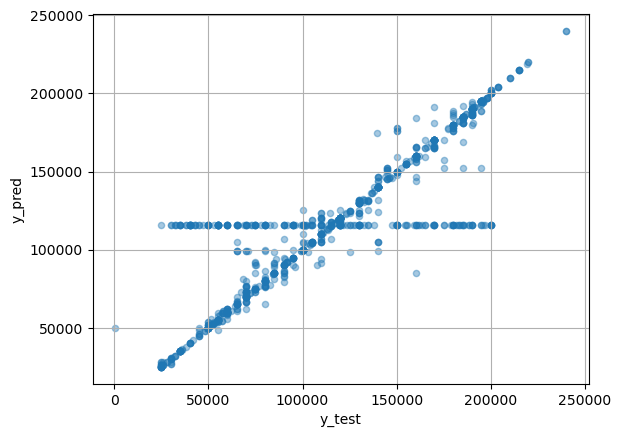

In [598]:
"""The line in the center is the fallback"""
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [599]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):

        #X and y are the ones from the training set
        self.col_price_mapper_ = y.groupby([X[col] for col in self.cols]).mean().rename("y_hat")
        self.fallback_price_s_ = y.mean()

    def predict(self, X):
        
        """We can assume that X contains a column named self.col"""
        out = X.join(self.col_price_mapper_, on = self.cols)
        out = out["y_hat"]
        out = out.fillna(self.fallback_price_s_) #What we didn't predict well will be in fallback price
        return out

score_board = {}
score_board_mse = {}

for col in X_train.columns:
    reg = MySuperModel(cols=[col])  # Initialize the MySuperModel class with the current column
    reg.fit(X_train, y_train)  # Fit using the entire training dataset
    y_pred = reg.predict(X_test)  # Predict using the entire test dataset


    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_mse = mean_absolute_error(y_test, y_pred)
    score_board_mse[col] = my_mse

In [601]:
#Base evaluation funtion
pd.Series(score_board)

Age                    0.302521
Gender                 0.163399
Education Level        0.197012
Job Title              0.333333
Years of Experience    0.350140
Country                0.134454
Race                   0.136321
height                 0.117647
weight                 0.117647
professionalism        0.471522
dtype: float64

In [602]:
from itertools import combinations

score_board = {}
score_board_mse = {}

# Iterate through all possible combinations of columns
for num_cols in range(1, len(X_train.columns) + 1):
    for col_combo in combinations(X_train.columns, num_cols):
        reg = MySuperModel(cols=list(col_combo))
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
        score_board[col_combo] = my_score
        print(f"Columns: {col_combo}, My Score: {my_score:.4f}")

        #my_mse = mean_absolute_error(y_test, y_pred)
        #score_board_mse[col] = my_mse


Columns: ('Age',), My Score: 0.3025
Columns: ('Gender',), My Score: 0.1634
Columns: ('Education Level',), My Score: 0.1970
Columns: ('Job Title',), My Score: 0.3333
Columns: ('Years of Experience',), My Score: 0.3501
Columns: ('Country',), My Score: 0.1345
Columns: ('Race',), My Score: 0.1363
Columns: ('height',), My Score: 0.1176
Columns: ('weight',), My Score: 0.1176
Columns: ('professionalism',), My Score: 0.4715
Columns: ('Age', 'Gender'), My Score: 0.2997
Columns: ('Age', 'Education Level'), My Score: 0.4034
Columns: ('Age', 'Job Title'), My Score: 0.6788
Columns: ('Age', 'Years of Experience'), My Score: 0.3875
Columns: ('Age', 'Country'), My Score: 0.2894
Columns: ('Age', 'Race'), My Score: 0.2754
Columns: ('Age', 'height'), My Score: 0.1176
Columns: ('Age', 'weight'), My Score: 0.1176
Columns: ('Age', 'professionalism'), My Score: 0.4463
Columns: ('Gender', 'Education Level'), My Score: 0.2110
Columns: ('Gender', 'Job Title'), My Score: 0.3856
Columns: ('Gender', 'Years of Expe

In [603]:
#Base evaluation funtion
best_combination = max(score_board, key=score_board.get)
best_score = score_board[best_combination]

print(f"Best Combination: {best_combination}, Best Score: {best_score:.4f}")


Best Combination: ('Education Level', 'Job Title', 'professionalism'), Best Score: 0.8562


In [606]:
reg = MySuperModel(cols = ['Education Level', 'Job Title', 'professionalism'])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

rmse = mean_squared_error(y_test, y_pred, squared=False) #18887
rmse


18887.78063973396

<Axes: xlabel='y_test', ylabel='y_pred'>

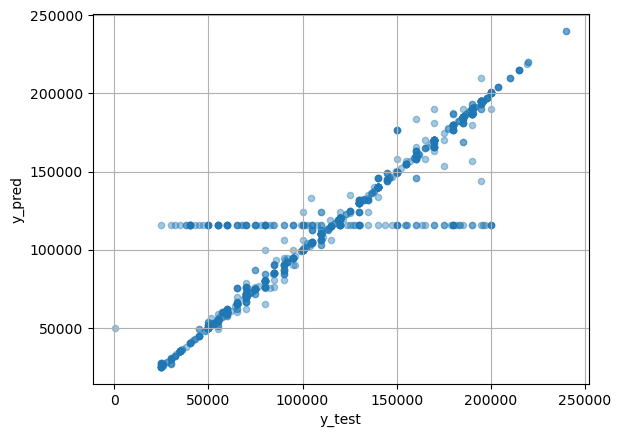

In [607]:
"""The line in the center is the fallback"""
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [232]:
X_test.iloc[1].to_dict()

{'Age': 44.0,
 'Gender': 'F',
 'Education Level': 'p',
 'Job Title': 'senior|project|enginee',
 'Years of Experience': 15.0,
 'Country': 'canad',
 'Race': 'White',
 'height': 1.8629780246998613,
 'weight': 70.53635110713462,
 'professionalism': 602.0}

In [233]:
object_ = {'Age': 44.0,
            'Gender': 'F',
            'Education Level': 'p',
            'Job Title': 'senior|project|enginee',
            'Years of Experience': 15.0,
            'Country': 'canad',
            'Race': 'White',
            'height': 1.8629780246998613,
            'weight': 70.53635110713462,
            'professionalism': 602.0}


def predict_model(object_):
    assert(set(reg.cols)&set(object_.keys()) == set(reg.cols))
    object_ = pd.Series(object_).to_frame().T
    return reg.predict(object_).iloc[0]

predict_model(object_)


190000.0

In [234]:
y_test.iloc[0]

150000.0

In [235]:
#this is the columns we must have as an input
reg.cols

['Education Level', 'Job Title', 'professionalism']

Transformer

In [683]:
#Copy
#Run this for raw data
z_df = input_df.copy()

In [609]:
#Check data shape
print(z_df.shape)

#Columns and type
print(z_df.info())

(5355, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5355 entries, 2477 to 3572
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5355 non-null   float64
 1   Gender               5355 non-null   object 
 2   Education Level      5355 non-null   object 
 3   Job Title            5355 non-null   object 
 4   Years of Experience  5355 non-null   float64
 5   Country              5355 non-null   object 
 6   Race                 5355 non-null   object 
 7   height               5355 non-null   float64
 8   weight               5355 non-null   float64
 9   professionalism      5355 non-null   float64
 10  Salary               5355 non-null   float64
dtypes: float64(6), object(5)
memory usage: 631.1+ KB
None


In [610]:
print(z_df.shape)

(5355, 11)


In [438]:
z_df.describe()
z_df["height"].min()
z_df[z_df["height"]==1.5002764877548087]#cm/inch?
z_df["weight"].min()#pound/kg?
"""Removing some bad things"""
print(len(z_df))

5355


In [631]:
z_df.describe()

,Age,Years of Experience,height,weight,professionalism,Salary
count,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000
mean,35.151634,9.620448,2.002327,66.899744,316.499627,115641.285154
std,7.616544,6.077945,0.292174,18.166318,305.097897,52763.590790
min,22.000000,1.000000,1.500276,13.637206,0.000000,500.000000
25%,29.000000,5.000000,1.750666,53.893328,84.000000,70000.000000
50%,33.000000,8.000000,2.000633,64.747191,217.000000,115000.000000
75%,39.000000,13.000000,2.261611,78.370881,451.000000,160000.000000
max,64.000000,36.000000,2.499932,139.997724,2040.000000,250000.000000


Outliner

<Axes: xlabel='Years of Experience', ylabel='Age'>

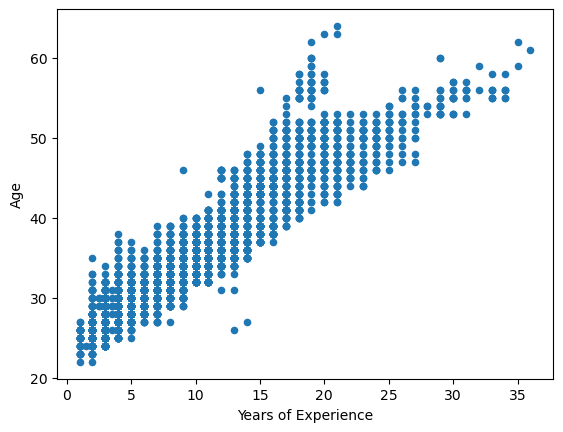

In [612]:
z_df.plot.scatter("Years of Experience","Age")

<Axes: xlabel='professionalism', ylabel='Years of Experience'>

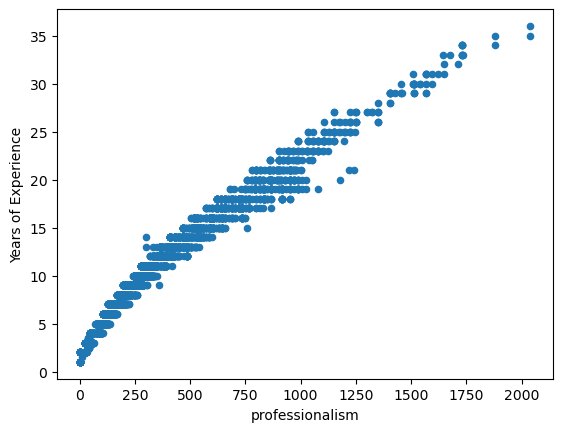

In [613]:
z_df.plot.scatter("professionalism","Years of Experience")

<Axes: xlabel='professionalism', ylabel='Years of Experience'>

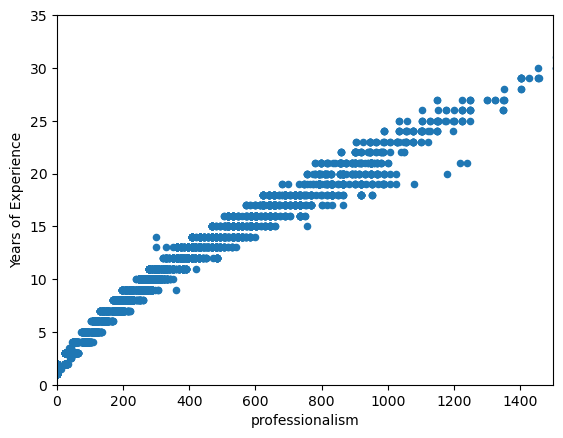

In [440]:
#Zoom in
z_df.plot.scatter("professionalism","Years of Experience",xlim=(0,1500),ylim=(0,35))


<Axes: xlabel='Years of Experience', ylabel='Age'>

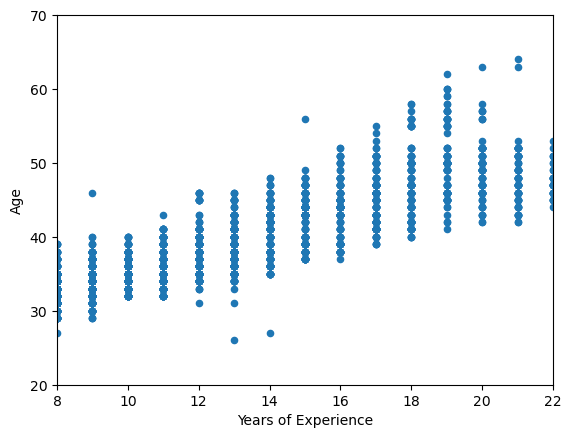

In [417]:
#Zoom in
z_df.plot.scatter("Years of Experience","Age",xlim=(8,22),ylim=(20,70))


<Axes: ylabel='Frequency'>

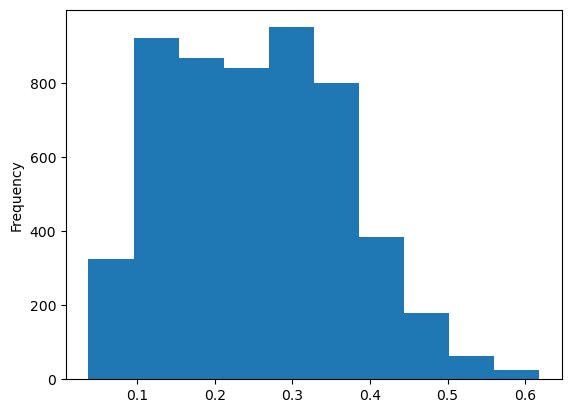

In [434]:
(z_df["Years of Experience"]/z_df["Age"]).plot.hist()

<Axes: ylabel='Frequency'>

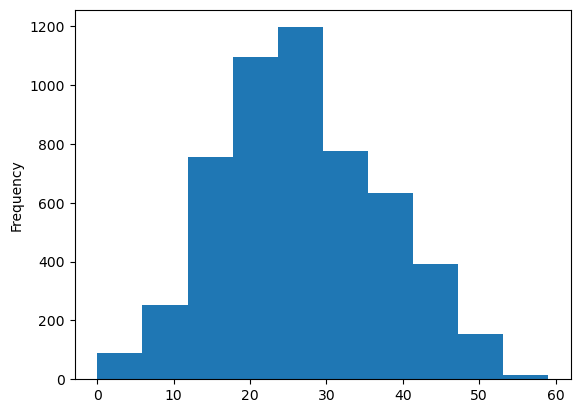

In [442]:
(z_df["professionalism"]/z_df["Years of Experience"]).plot.hist()


In [614]:
z_df[(z_df["Years of Experience"]/z_df["Age"]).between(0.00,2)]


,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...
354,32.0,F,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0
3677,44.0,M,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0
6032,25.0,M,high|scho,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,28000.0


In [616]:
z_df[(z_df["professionalism"]/z_df["Years of Experience"]).between(0.00,1500)]

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...
354,32.0,F,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0
3677,44.0,M,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0
6032,25.0,M,high|scho,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,28000.0


<Axes: ylabel='Frequency'>

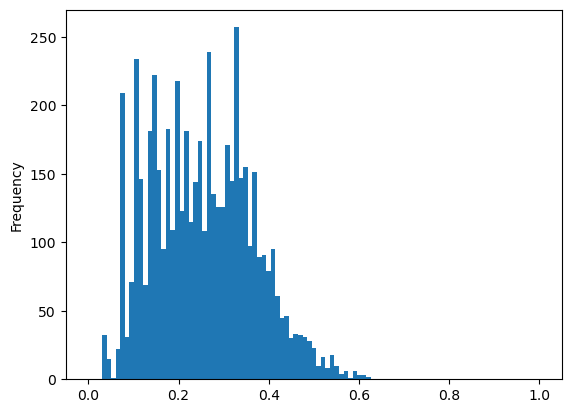

In [445]:
(z_df["Years of Experience"]/z_df["Age"]).plot.hist(bins = np.linspace(0, 1, 100))

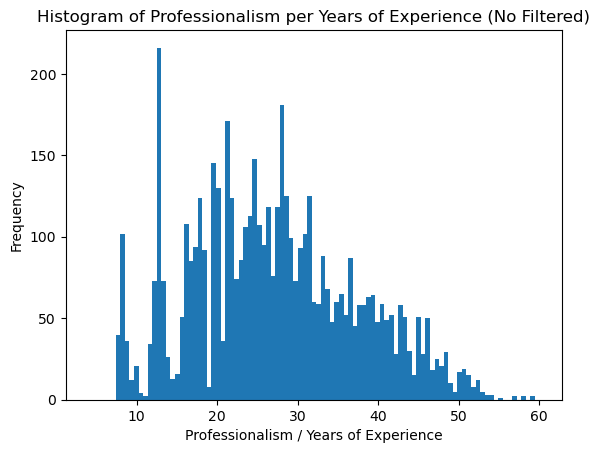

In [619]:
(z_df["professionalism"]/z_df["Years of Experience"]).plot.hist(bins = np.linspace(4, 60, 100))
plt.xlabel('Professionalism / Years of Experience')
plt.ylabel('Frequency')
plt.title('Histogram of Professionalism per Years of Experience (No Filtered)')
plt.show()

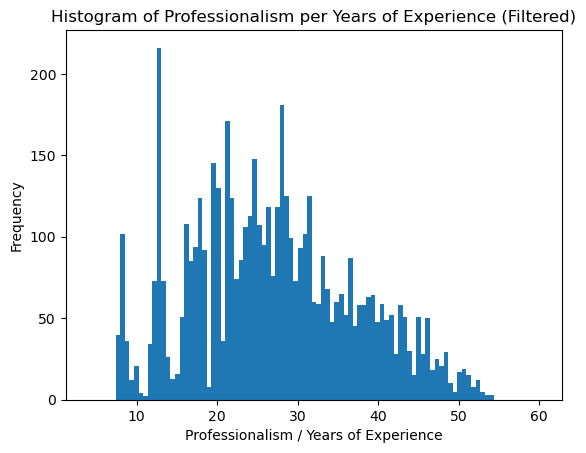

5355
5259


In [507]:
Ratio = z_df["professionalism"]/z_df["Years of Experience"]
Ratio = Ratio[Ratio.between(5, 55)]
Ratio.plot.hist(bins = np.linspace(4, 60, 100))
plt.xlabel('Professionalism / Years of Experience')
plt.ylabel('Frequency')
plt.title('Histogram of Professionalism per Years of Experience (Filtered)')
plt.show()
print(len(z_df))
print(len(Ratio))

In [684]:
Ratio = Ratio[Ratio.between(5, 55)]

id
2477    47.916667
76      47.826087
64      13.000000
924     25.363636
242     34.545455
          ...    
1744    17.400000
354     23.250000
3677    36.400000
3278    25.000000
3572     9.000000
Length: 5259, dtype: float64

In [620]:
#Copy
#Run this for raw data
z_df = input_df.copy()

Ratio_keeper = 0.05
z_df = z_df[(z_df["Years of Experience"]/z_df["Age"]).between(0.00,2)]
z_df["Ratio"] = z_df["Years of Experience"]/z_df["Age"]
print(z_df["Ratio"].max())
print(z_df["Ratio"].min())
z_df["Ratio"].sort_values()

0.6181818181818182
0.037037037037037035


id
5285    0.037037
5313    0.037037
5217    0.038462
49      0.038462
6074    0.038462
          ...   
2820    0.607143
2871    0.607143
3015    0.607143
2846    0.618182
2896    0.618182
Name: Ratio, Length: 5355, dtype: float64

In [701]:
#Copy
#Run this for raw data
z_df = input_df.copy()

In [702]:
z_df.describe()

,Age,Years of Experience,height,weight,professionalism,Salary
count,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000,5355.000000
mean,35.151634,9.620448,2.002327,66.899744,316.499627,115641.285154
std,7.616544,6.077945,0.292174,18.166318,305.097897,52763.590790
min,22.000000,1.000000,1.500276,13.637206,0.000000,500.000000
25%,29.000000,5.000000,1.750666,53.893328,84.000000,70000.000000
50%,33.000000,8.000000,2.000633,64.747191,217.000000,115000.000000
75%,39.000000,13.000000,2.261611,78.370881,451.000000,160000.000000
max,64.000000,36.000000,2.499932,139.997724,2040.000000,250000.000000


In [677]:
#z_df[z_df["professionalism"]==0] #89 raws
#z_df = z_df[z_df["professionalism"]!= 0]
#print(len(z_df))


5266


In [716]:


Ratio_keeper = 0.05

#Copy
#Run this for raw data
z_df = input_df.copy()

print(len(z_df))
z_df[(z_df["professionalism"] / z_df["Years of Experience"]).between(1-Ratio_keeper, 1+Ratio_keeper)] #What is 100%

z_df = z_df[(z_df["professionalism"] / z_df["Years of Experience"]).between(5,60)] 

print(len(z_df))

z_df["Ratio"] = (z_df["professionalism"] / z_df["Years of Experience"])
z_df["Ratio"].sort_values()

volume_normad = (z_df['Ratio']-z_df['Ratio'].mean())/z_df['Ratio'].std()
z_df = z_df[volume_normad.between(-3,3)]
len(z_df)


5355
5266
59.04761904761905
7.666666666666667


,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Ratio
id,,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,47.916667
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,47.826087
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,13.000000
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,25.363636
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,34.545455


In [710]:
(z_df['Ratio']-z_df['Ratio'].mean())/z_df['Ratio'].std()

id
2477    2.018683
76      2.009906
64     -1.364518
924    -0.166561
242     0.723098
          ...   
1744   -0.938186
354    -0.371359
3677    0.902792
3278   -0.201795
3572   -1.752092
Name: Ratio, Length: 5266, dtype: float64

In [693]:
z_df.loc[76]

Age                                 52.0
Gender                                 F
Education Level                 bachelor
Job Title              operations|manage
Years of Experience                 23.0
Country                               us
Race                               White
height                          2.451414
weight                         87.456039
professionalism                   1100.0
Salary                          160000.0
Ratio                          47.826087
Name: 76, dtype: object

In [711]:
#z_df = df[(z_df["professionalism"] / z_df["Years of Experience"]).between(1-Ratio_Keeper, 1+Ratio_Keeper)]
volume_normad = (z_df['Ratio']-z_df['Ratio'].mean())/z_df['Ratio'].std()
volume_normad.sort_values()

id
2272   -1.881284
2374   -1.881284
2340   -1.881284
1325   -1.881284
3354   -1.881284
          ...   
1260    2.883500
1277    3.004921
2501    3.023377
1305    3.082897
1304    3.097200
Name: Ratio, Length: 5266, dtype: float64

In [714]:
z_df = z_df[volume_normad.between(-3,3)]
len(z_df)

5262

STD and removing outliers

In [819]:
#Ratio_keeper = 0.05
OUTLIER_DEFINITION = 3

def remove_outliers(input_df, outlier_definition = 3):
    #Copy
    z_df = input_df.copy()

    #Removing some bad things

    #z_df[(z_df["professionalism"] / z_df["Years of Experience"]).between(1-Ratio_keeper, 1+Ratio_keeper)] #What is 100%

    z_df = z_df[(z_df["professionalism"] / z_df["Years of Experience"]).between(5,60)] 
    z_df["Ratio"] = (z_df["professionalism"] / z_df["Years of Experience"])

    volume_normad = (z_df['Ratio']-z_df['Ratio'].mean())/z_df['Ratio'].std()
    z_df = z_df[volume_normad.between(-1 * outlier_definition, 1 * outlier_definition)]

    return z_df    

df = remove_outliers(input_df,outlier_definition = OUTLIER_DEFINITION)

In [820]:
print(input_df.shape)
print(df.shape)

(5355, 11)
(5262, 12)


In [734]:

df["Education Level"]

id
2477                       back|end|develope
76                         operations|manage
64                          junior|accountan
924                              data|analys
242                    senior|product|manage
                        ...                 
1744                       back|end|develope
354     junior|business|development|associat
3677                           data|scientis
3278                        software|enginee
3572                     junior|hr|generalis
Name: Job Title, Length: 5262, dtype: object

In [830]:
df["Ratio"]

id
2477    47.916667
76      47.826087
64      13.000000
924     25.363636
242     34.545455
          ...    
1744    17.400000
354     23.250000
3677    36.400000
3278    25.000000
3572     9.000000
Name: Ratio, Length: 5262, dtype: float64

One-Hot Encoding

In [838]:
one_hot_encoded = pd.get_dummies(df["Education Level"], prefix="Job")
df = pd.concat([df, one_hot_encoded], axis=1)

Target Encoding

In [740]:
df["Job Title"]

id
2477                       back|end|develope
76                         operations|manage
64                          junior|accountan
924                              data|analys
242                    senior|product|manage
                        ...                 
1744                       back|end|develope
354     junior|business|development|associat
3677                           data|scientis
3278                        software|enginee
3572                     junior|hr|generalis
Name: Job Title, Length: 5262, dtype: object

In [839]:
import category_encoders as ce

target_encoder = ce.TargetEncoder()
df["Job Title Encoded"] = target_encoder.fit_transform(df["Job Title"], df["Salary"])


In [840]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Ratio,Job_bachelor,Job_bachelor's|degr,Job_high|scho,Job_master,Job_master's|degr,Job_p,Job Title Encoded
id,,,,,,,,,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,47.916667,0,1,0,0,0,0,103767.631102
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,47.826087,1,0,0,0,0,0,95347.979198
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,13.000000,1,0,0,0,0,0,105387.504098
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,25.363636,1,0,0,0,0,0,125118.705036
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,34.545455,1,0,0,0,0,0,115427.680206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,30.0,F,master's|degr,back|end|develope,5.0,australi,Asian,2.189504,41.395949,87.0,90000.0,17.400000,0,0,0,0,1,0,103767.631102
354,32.0,F,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,23.250000,1,0,0,0,0,0,100684.469515
3677,44.0,M,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0,36.400000,0,0,0,0,0,1,166034.285714


In [842]:
input_df.iloc[0].to_dict()

{'Age': 52.0,
 'Gender': 'M',
 'Education Level': "bachelor's|degr",
 'Job Title': 'back|end|develope',
 'Years of Experience': 24.0,
 'Country': 'australi',
 'Race': 'Asian',
 'height': 1.8003155145639764,
 'weight': 95.02195734157718,
 'professionalism': 1150.0,
 'Salary': 175966.0}

In [823]:
one_raw = {'Age': 52.0,
 'Gender': 'M',
 'Education Level': "bachelor's|degr",
 'Job Title': 'back|end|develope',
 'Years of Experience': 24.0,
 'Country': 'australi',
 'Race': 'Asian',
 'height': 1.8003155145639764,
 'weight': 95.02195734157718,
 'professionalism': 1150.0,
 'Salary': 175966.0}

In [759]:
"""Check Nulls"""
input_df.isna().mean()

Age                    0.0
Gender                 0.0
Education Level        0.0
Job Title              0.0
Years of Experience    0.0
Country                0.0
Race                   0.0
height                 0.0
weight                 0.0
professionalism        0.0
Salary                 0.0
dtype: float64

In [851]:
class Mytransformer:
    """ 
    A transformer that transforms the column "col" from "raw" variant into standardized variant
    """
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        self.avg_ = X[self.col].mean()
        self.std_ = X[self.col].std()

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.col] = (X[self.col] - self.avg_) / self.std_
        # Apply your categorization logic for "Job Title" and "Education Level" here
        return X_transformed
    
column_transformer = Mytransformer(col = 'Ratio')
column_transformer.fit(df)
 

In [849]:
one_raw = {'Age': 52.0,
 'Gender': 'M',
 'Education Level': "bachelor's|degr",
 'Job Title': 'back|end|develope',
 'Years of Experience': 24.0,
 'Country': 'australi',
 'Race': 'Asian',
 'height': 1.8003155145639764,
 'weight': 95.02195734157718,
 'professionalism': 1150.0,
 'Ratio': 13,
 'Salary': 175966.0}

one_raw = pd.Series(one_raw).to_frame().T

df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Ratio,Job_bachelor,Job_bachelor's|degr,Job_high|scho,Job_master,Job_master's|degr,Job_p,Job Title Encoded
id,,,,,,,,,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,47.916667,0,1,0,0,0,0,103767.631102
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,47.826087,1,0,0,0,0,0,95347.979198
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,13.000000,1,0,0,0,0,0,105387.504098
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,25.363636,1,0,0,0,0,0,125118.705036
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,34.545455,1,0,0,0,0,0,115427.680206


In [852]:
column_transformer.transform(one_raw)



,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Ratio,Salary
0,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,-1.366529,175966.0


In [748]:

volume_normad = (z_df['Ratio']-z_df['Ratio'].mean())/z_df['Ratio'].std()

id
2477    47.916667
76      47.826087
64      13.000000
924     25.363636
242     34.545455
          ...    
1744    17.400000
354     23.250000
3677    36.400000
3278    25.000000
3572     9.000000
Name: Ratio, Length: 5262, dtype: float64